In [1]:
# Required libraries
import dowhy
from dowhy import CausalModel
import dowhy.datasets

# Avoiding unnecessary log messges and warnings
import logging
logging.getLogger("dowhy").setLevel(logging.WARNING)
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

# Load some sample data
data = dowhy.datasets.linear_dataset(
    beta=10,
    num_common_causes=5,
    num_instruments=2,
    num_samples=10000,
    treatment_is_binary=True,
    stddev_treatment_noise=10)

In [3]:
data['df']

,Z0,Z1,W0,W1,W2,W3,W4,v0,y
0,0.0,0.981328,-1.849326,2.078762,0.339649,-0.362884,-1.349004,False,-5.669051
1,0.0,0.193851,-1.322927,0.745492,1.499576,-1.049523,-0.985397,False,-4.967147
2,0.0,0.017952,1.475782,1.011442,1.421180,0.702996,-1.910280,True,9.591245
3,0.0,0.098149,0.175413,0.486244,1.017607,-0.761047,2.473459,True,23.797166
4,1.0,0.118028,1.221368,0.520263,0.119884,-1.292540,0.915852,True,18.615992
...,...,...,...,...,...,...,...,...,...
9995,0.0,0.105375,1.496367,0.178222,0.446736,0.809522,-0.985463,True,10.761503
9996,0.0,0.927619,-0.024045,-0.365099,1.498647,-0.906434,0.271229,True,11.529233
9997,0.0,0.716673,0.069553,-0.311309,2.490069,-0.911853,-1.801529,True,3.529486
9998,0.0,0.448981,-1.348006,0.994708,-0.382817,0.137648,0.330627,False,-0.023710


In [4]:
data["treatment_name"]

['v0']

In [5]:
data["outcome_name"]

'y'

In [6]:
data["common_causes_names"]

['W0', 'W1', 'W2', 'W3', 'W4']

In [7]:
data["instrument_names"]

['Z0', 'Z1']

In [9]:
# I. Create a causal model from the data and domain knowledge.
model = CausalModel(
    data=data["df"],
    treatment=data["treatment_name"],
    outcome=data["outcome_name"],
    common_causes=data["common_causes_names"],
    instruments=data["instrument_names"])

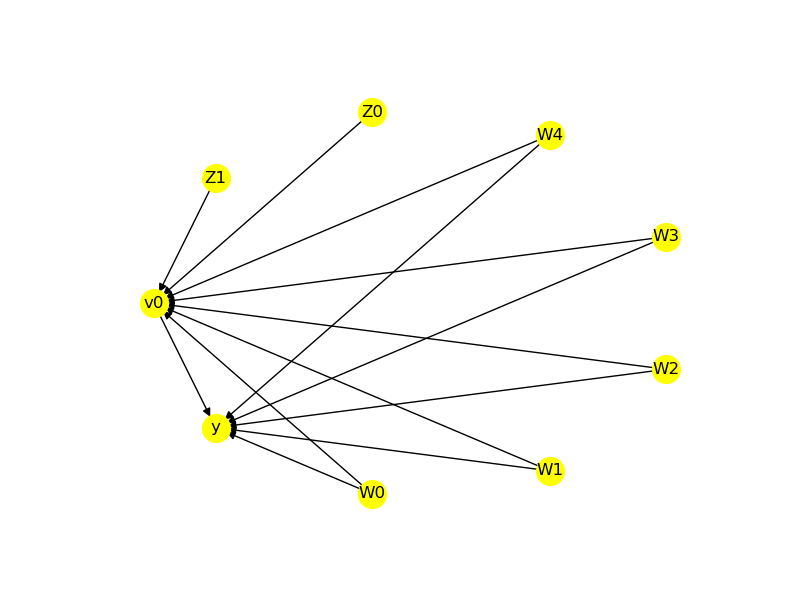

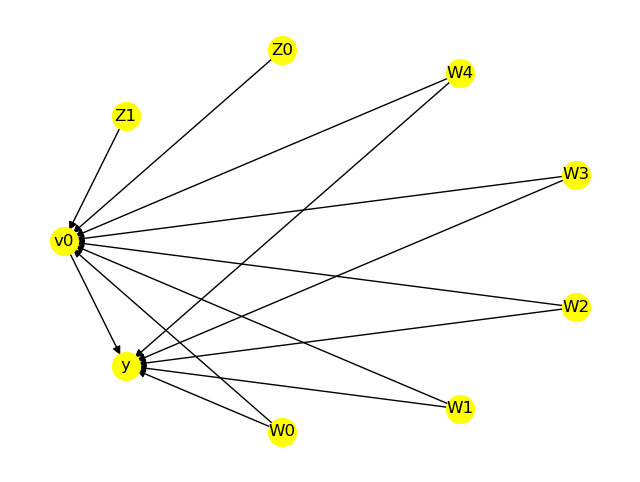

In [10]:
model.view_model(layout="dot")
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [12]:
data["gml_graph"]

'graph[directed 1node[ id "y" label "y"]node[ id "W0" label "W0"] node[ id "W1" label "W1"] node[ id "W2" label "W2"] node[ id "W3" label "W3"] node[ id "W4" label "W4"]node[ id "Z0" label "Z0"] node[ id "Z1" label "Z1"]node[ id "v0" label "v0"]edge[source "v0" target "y"]edge[ source "W0" target "v0"] edge[ source "W1" target "v0"] edge[ source "W2" target "v0"] edge[ source "W3" target "v0"] edge[ source "W4" target "v0"]edge[ source "Z0" target "v0"] edge[ source "Z1" target "v0"]edge[ source "W0" target "y"] edge[ source "W1" target "y"] edge[ source "W2" target "y"] edge[ source "W3" target "y"] edge[ source "W4" target "y"]]'

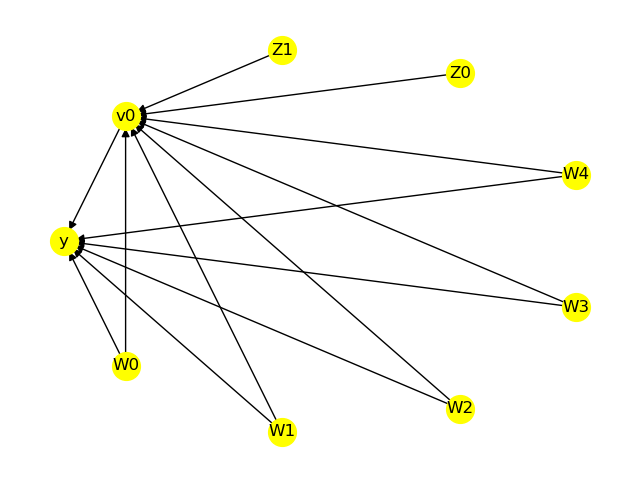

In [11]:
# I. Create a causal model from the data and given graph.
model = CausalModel(
    data=data["df"],
    treatment=data["treatment_name"][0],
    outcome=data["outcome_name"][0],
    graph=data["gml_graph"])
model.view_model(layout="dot")

In [13]:
# II. Identify causal effect and return target estimands
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W1,W0,W2,W4,W3])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,W2,W4,W3,U) = P(y|v0,W1,W0,W2,W4,W3)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₀  Z₁]    ⎝d[Z₀  Z₁]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [14]:
propensity_strat_estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.dowhy.propensity_score_stratification")

print(propensity_strat_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W1,W0,W2,W4,W3])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,W2,W4,W3,U) = P(y|v0,W1,W0,W2,W4,W3)

## Realized estimand
b: y~v0+W1+W0+W2+W4+W3
Target units: ate

## Estimate
Mean value: 9.970759565395792



In [15]:
import econml
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, 
                                    method_name="backdoor.econml.dml.DML",
                                    method_params={
                                        'init_params': {'model_y':GradientBoostingRegressor(),
                                                        'model_t': GradientBoostingRegressor(),
                                                        'model_final':LassoCV(fit_intercept=False), },
                                        'fit_params': {}
                                     })
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W1,W0,W2,W4,W3])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,W2,W4,W3,U) = P(y|v0,W1,W0,W2,W4,W3)

## Realized estimand
b: y~v0+W1+W0+W2+W4+W3 | 
Target units: ate

## Estimate
Mean value: 9.971532714596178
Effect estimates: [9.97153271 9.97153271 9.97153271 ... 9.97153271 9.97153271 9.97153271]

